In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [2]:
# 1. Đọc file csv và gắng index với giá Close
data = pd.read_csv('BNB2019-2024.csv')
data1=data.reset_index()['Close']

In [3]:
# 2. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(np.array(data1).reshape(-1, 1))

In [4]:
# 3. Chia train test
train_size = int(0.6 * len(data1))
test_size = len(data1) - train_size

train_data = data1[:train_size]
test_data = data1[train_size:]

In [5]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [6]:
# 5. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 7. Định nghĩa LSTM Model với Adam Optimizer
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Sử dụng Adam optimizer
optimizer = Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=optimizer)

C:\Users\KIM ANH\anaconda3\envs\lab1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step - loss: 0.0521
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 0.0072
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.0060
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.0045
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 0.0037
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0040
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.0035
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0031
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.0027
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0035
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.0026
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0024
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0022
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0022
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s

In [10]:
# 9. Trích xuất đặc trưng bằng mô hình LSTM
feature_extractor = Sequential()
feature_extractor.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [11]:
# 10. Chuẩn bị dữ liệu cho LightGBM
lgb_train = lgb.Dataset(features_train, label=y_train)
lgb_test = lgb.Dataset(features_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# 11. Huấn luyện mô hình LightGBM
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6535
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 37
[LightGBM] [Info] Start training from score 0.247783


In [12]:
# 12. Dự đoán và đánh giá
y_pred_scaled = gbm.predict(features_test, num_iteration=gbm.best_iteration)

In [13]:
# Đưa kết quả dự đoán và thực tế về dạng gốc
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:
# Tính toán các chỉ số RMSE, MAPE, MSE
rmse = np.sqrt(np.mean((y_pred - y_test_orig)**2))
mse = mean_squared_error(y_test_orig, y_pred)
mape = mean_absolute_percentage_error(y_test_orig, y_pred)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 25.82735521660727
MSE: 667.0522774848107
MAPE: 0.08488891334059048


In [15]:
# 13. Dự báo tương lai sử dụng LSTM + LightGBM
def predict_future(feature_extractor, gbm, data, steps, time_step):
    temp_input = list(data[-time_step:].flatten())
    lst_output = []
    i = 0
    while(i < steps):
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        lstm_features = feature_extractor.predict(x_input, verbose=0)
        yhat = gbm.predict(lstm_features)
        temp_input.extend(yhat.flatten().tolist())
        lst_output.extend(yhat.flatten().tolist())
        i += 1
    return lst_output

In [16]:
# Dự báo 30, 60, 90 ngày tiếp theo

pred_90_days = predict_future(feature_extractor, gbm, test_data, 90, time_step)

# Đưa dự báo về dạng gốc
pred_30_days = scaler.inverse_transform(np.array(pred_90_days[:30]).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_90_days[30:60]).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days[60:]).reshape(-1, 1))

In [17]:
# 14. Vẽ biểu đồ dự đoán
def plot_predictions(train_data, test_data, pred_30_days, pred_60_days, pred_90_days):
    plt.figure(figsize=(14, 7))
    plt.plot(pd.RangeIndex(start=0, stop=train_size, step=1), scaler.inverse_transform(train_data), label='Train')
    plt.plot(pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1), scaler.inverse_transform(test_data), label='Test')
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred),label='Predict')
    # Vẽ biểu đồ dự đoán cho 30 ngày
    plt.plot(pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+30, step=1), pred_30_days, label='Predict 30 days')
    
    # Vẽ biểu đồ dự đoán cho 60 ngày
    plt.plot(pd.RangeIndex(start=train_size+test_size+30, stop=train_size+test_size+60, step=1), pred_60_days, label='Predict 60 days')
    
    # Vẽ biểu đồ dự đoán cho 90 ngày
    plt.plot(pd.RangeIndex(start=train_size+test_size+60, stop=train_size+test_size+90, step=1), pred_90_days, label='Predict 90 days')
    
    plt.title('LSTM + LightGBM BNB2019-2024 6:4 Predict')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


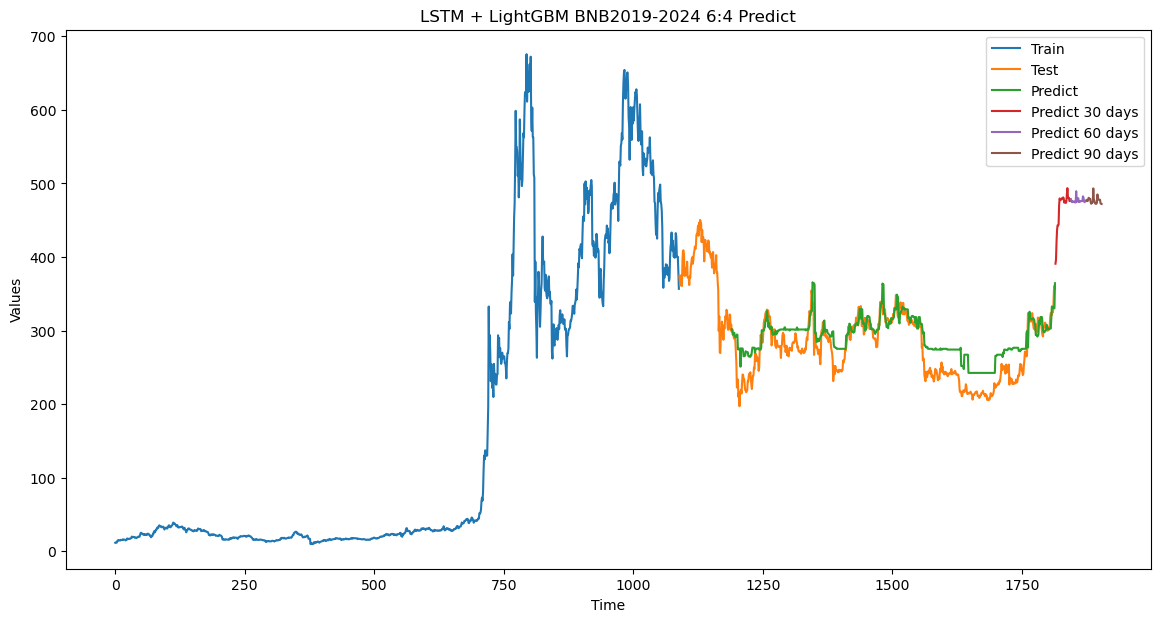

In [18]:
# Vẽ biểu đồ dự đoán
plot_predictions(train_data, test_data, pred_30_days, pred_60_days, pred_90_days)